In [1]:
from __future__ import annotations

import random
import shutil

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from utils_to_build_QAOAAnsatz import *
from info_dim6 import info_dim6

In [2]:
def custom_sort(file_name: str, string_order: List[str]) -> int:
    """
    Returns the index of the first matching string from `string_order` in `file_name`.
    If no match is found, returns the length of `string_order`, placing unmatched files at the end.

    Parameters:
    file_name (str): The file name to be sorted.
    string_order (list[str]): The order of strings to match.

    Returns:
    int: The index of the first match or the length of `string_order` if no match.
    """
    for idx, key in enumerate(string_order):
        if key in file_name:
            return idx
    return len(string_order)  # Place unmatched files at the end

In [3]:
def from_file_to_percentage(filename: str,
                            txt: str,
                            p: int,
                            random_attempts: int) -> pd.DataFrame:
    """
    Computes the percentage of each value in the CSV file relative to the total,
    along with the average, max, and min values per row. It also identifies the best
    histogram index from a metadata file and sorts the data based on that index.

    Parameters:
    filename (str): Path to the CSV file containing the data.
    txt (str): Path to the metadata file used to identify the best histogram index.
    p (int): The parameter `p` used in the best histogram column name.
    random_attempts (int): The number of random attempts used in the best histogram column name.

    Returns:
    pd.DataFrame: A DataFrame with the percentage of values, average, max, and min,
                  sorted based on the best histogram index.
    """
    # Load data from CSV file
    df = pd.read_csv(filename, dtype=str).set_index('states')
    df = df.astype(float).fillna(0.0)

    # Compute percentages and additional columns
    total = df.sum()
    percentage = (df / total) * 100
    percentage['average'] = percentage.mean(numeric_only=True, axis=1)
    percentage['max'] = percentage[percentage.columns[:-1]].max(axis=1)
    percentage['min'] = percentage[percentage.columns[:-1]].min(axis=1)

    # Find the best histogram index from metadata file
    with open(txt, 'r') as data_file:
        for line in data_file:
            if 'Attempt that reached the best result with' in line:
                string = line.split('#')[1]
                i_best = string.split(' ')[0]

    column_best = f'counts_p{p}_{i_best}of{random_attempts}'
    percentage = percentage[[column_best, "average", "max", "min"]]
    percentage = percentage.sort_values(column_best, ascending=False)

    return percentage

In [4]:
def set_titles(parameters: Tuple[int, int, str, float, int, int]) -> Tuple[str, str]:
    """
    Constructs and returns the subplot and figure titles for a plot based on the provided parameters.
    
    Parameters
    ----------
    parameters (tuple): A tuple containing the following elements:
        - n (int): A parameter related to the system size.
        - instance (int): An identifier for the specific instance.
        - init_name (str): The initialization type (e.g., "all1", "all0").
        - p (float): A probability parameter.
        - random_attempts (int): The number of random attempts.
        - k (int): A parameter related to the setting of k.
    dont_show_in_title (list of str):
        A list of keys that should be excluded from the subplot title.
    dont_show_in_titles (list of str):
        A list of keys that should be excluded from both the subplot and figure titles.

    Returns
    -------
    title_string (str): The subplot title with the relevant parameters.
    figure_title_string (str): The figure title with the relevant parameters.

    Example
    -------
    >>> set_titles((10, 1, "all1", 0.5, 10, 3), ["k"], ["p"])
    ('n=10, Instance #1, $|1 \\rangle$-initialization, ra=10',
     'Performance of different k settings\nn=10, Instance #1, $|1 \\rangle$-initialization, ra=10, k=3')
    """
    n, instance, init_name, p, random_attempts, k = parameters
    
    # Highlight initialization states in the plot
    if init_name == "all1":
        init_string = "$|1 \\rangle$-initialization"
    elif init_name == "all0":
        init_string = "$|0 \\rangle$-initialization"
    else:
        init_string = ""

    # Construct a dictionary of formatted strings
    dictstring = {"n": f"$n={n}$",
                  "i": f"Instance #{instance}",
                  "init": f"{init_string}",
                  "p": f"$p={p}$",
                  "ra": f"$ra={random_attempts}$",
                  "k": f"$k={k}$"
                  }
    
    dont_show_in_title = ["i", "k"]  # Keys to omit from the figure title
    dont_show_in_titles = ["n", "p", "ra", "k", "init"]  # Keys to omit from subplot titles

    # Create figure title string
    figure_title_string = "Performance of different k settings\n"
    figure_title_string += ", ".join(
        [dictstring[x] for x in dictstring if x not in dont_show_in_title])

    # Create subplot title string
    title_string = ', '.join([dictstring[x] for x in dictstring if x not in dont_show_in_titles])

    return title_string, figure_title_string

In [5]:
def customize_ax(ax: plt.Axes, fontsize: int, instance: int, num_cols: int) -> None:
    """
    Customizes the appearance of the plot axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes object to customize.
    - fontsize (int): The font size to use for tick labels and axis labels.
    - instance (int): The instance number used to conditionally set the y-axis label.
    - num_cols (int): The number of columns used to determine when to add the y-axis label.

    Returns:
    - None: This function modifies the axes in place.
    """
    ax.tick_params(axis='x', which='major', labelsize=fontsize - 1, rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=fontsize)

    ax.set_xlabel("States", fontsize=fontsize + 1)
    if instance % num_cols == 1:
        ax.set_ylabel("Percentage [%]", fontsize=fontsize + 1)

    ax.set_xlim(xmin=-1)
    ax.set_ylim(ymin=0, ymax=110)
    ax.minorticks_on()
    ax.grid(alpha=0.2)

In [6]:
def multiple_barplot(path: str, string_order: List[str]) -> None:
    """
    Creates subplots for each instance and plots multiple bar plots with 
    different colors based on the order of the string.
    Each subplot represents the performance of different instances, 
    highlighting states such as exact covers and initial states.

    Parameters
    ----------
    path : str
        The directory path where the files are stored.
    string_order : List[str]
        A list of strings that define the order for sorting the files.

    Returns
    -------
    None
        The function will display the plot and optionally save it as a file.

    Example
    -------
    multiple_barplot('/path/to/files', ['string1', 'string2'])
    """
    
    # Find all the instances that are in the merged folder.
    instances = set()
    for file_name in os.listdir("./merged_folder"):
        instances.add(extract_instance_from_filename(file_name))
    
    fontsize = 10  # Font size for the plot
    
    num_rows = math.ceil(np.sqrt(len(instances)))  # Number of rows for subplots
    num_cols = math.ceil(len(instances)/num_rows)  # Number of columns for subplots

    ##########################################################
    # Initialize the figure and axes for the subplots.
    # Each subplot displays an instance.
    fig, axes = plt.subplots(num_rows, num_cols, dpi=300, squeeze=False)
    axes = axes.flatten()

    # Iterate over the instances to create the subplots   
    for counter,instance in enumerate(instances):
        print(f"\nLoading instance {instance}...\n")
        ax = axes[counter]  # Get the subplot axis for the current instance
        
        # Find files related to the current instance
        substrings = [f"_mail{instance}_"]
        csv_list, txt_list = find_files_containing_string(path, substrings)

        # Sort the file lists
        csv_list = sorted(csv_list, key=lambda x: custom_sort(x, string_order))
        txt_list = sorted(txt_list, key=lambda x: custom_sort(x, string_order))

        print(f"  -> {len(csv_list)} csv files found")
       
        parameters = define_parameters_from_filename(csv_list[0], verbose=False)
        n, instance, init_name, p, random_attempts, k = parameters
        EXACT_COVERS = info_dim6[instance]["exact_covers"]
        MEC = info_dim6[instance]["mec"]
        
        ######################## SET COLORS #######################################
        # Each k in the csv list will have its own color.
        
        brightness = lambda x: sum(mcolors.to_rgb(x)) / 3

        # Exclude bright colors and black. Then sort.
        cols = sorted([name for name, hex in mcolors.CSS4_COLORS.items()
                       if 0.2 < brightness(hex) < 0.9 and name.lower() != 'black'])

        # Extract keys (value of k from each csv).
        keys = [define_parameters_from_filename(csv)[5] for csv in csv_list]
        
        # Each k will have its color.
        color_map = {key: cols[i] for i, key in enumerate(keys)}
        
        ###########################################################################
        
        # List to store combined data for plotting
        combined_data = []
        
        # Process each file pair (csv and txt)
        for (csv, txt) in zip(csv_list, txt_list):
            percentage = from_file_to_percentage(csv, txt, p, random_attempts)
            combined_data.append(percentage)
                    
        # Combine the DataFrames with MultiIndex and fill missing values with 0
        df = pd.concat(combined_data, axis=1, join='outer', keys=keys)
        
        # Flatten the MultiIndex columns
        df.columns = [f'{col[0]}_{col[1]}' for col in df.columns]
        
        # Fill missing values with 0
        df = df.fillna(0)
        
        colors = list(color_map.values())
        
        # Identify columns ending with specific suffixes
        count_columns = [col for col in df.columns if '_counts' in col]
        average_columns = [col for col in df.columns if col.endswith('_average')]
        max_columns = [col for col in df.columns if col.endswith('_max')]
        min_columns = [col for col in df.columns if col.endswith('_min')]
        
        bar_width = 0.3  # Bar width for the plot
        x_positions = range(len(df))  # X-axis positions for the bars

        ####################### PLOT THE BAR PLOTS ################################
        z = zip(count_columns, average_columns, max_columns, min_columns)
        for idx, (count_col, avg_col, max_col, min_col) in enumerate(z):
            offset = (idx - 1) * bar_width
        
            # Get color for the bar plot
            color = color_map[keys[idx]]
        
            # Create bar plot        
            bars = ax.bar([x + offset for x in x_positions], df[count_col], color=color,
                          alpha=1, label=f"{string_order[idx]}: {df[count_col].sum():.1f}%", width=bar_width)
        
            # Scatter plot with error bars for MEC
            for pos, state in enumerate(df.index):
                if state == MEC or state in EXACT_COVERS:
                    value = df.loc[state, avg_col]
                    max_value = df.loc[state, max_col]
                    min_value = df.loc[state, min_col]
        
                    # Calculate lower and upper error bars
                    lower_error = value - min_value
                    upper_error = max_value - value
        
                    ax.errorbar([pos + offset], [value],
                                yerr=[[lower_error], [upper_error]],  # Error bars
                                fmt='.', alpha=1, ecolor="k", color=color,
                                markerfacecolor=color, markeredgecolor='k', capthick=1, capsize=5, elinewidth=1,
                                zorder=2, markersize=8, linestyle='None')

        ################### ADJUST THE SUBPLOT ##############################
        title_string, figure_title_string = set_titles(parameters)
        ax.set_title(title_string, fontsize=fontsize)
        fig.suptitle(figure_title_string, fontsize=fontsize+3)

        
        # Add legend to the subplot
        legend_labels = []
        if MEC in df.index:
            for ii in range(len(color_map.keys())):
                value = df.loc[MEC, count_columns[ii]]
                legend_labels.append((f"MEC: {value:.1f}%", colors[ii]))

        handles = [plt.Line2D([0], [0], color=color, lw=4) for _, color in legend_labels]
        labels = [label for label, _ in legend_labels]
        
        first_legend = ax.legend(handles, labels, loc="upper right", fontsize=10)
        ax.add_artist(first_legend) 


        # Add legend to show what different colors in a subplot mean
        legend_handles = [mpatches.Patch(color=color, label=f"k = {key}")
                          for key, color in color_map.items()]

        second_legend = ax.legend(handles=legend_handles, loc='upper center',
                                  bbox_to_anchor=(0.5, 1.0), borderaxespad=0.,
                                  fontsize=fontsize, ncol=len(string_order))
        ax.add_artist(second_legend) 
        
        
        # Set x-axis labels to "states"
        ax.set_xticks(x_positions)  
        ax.set_xticklabels(df.index)  # Use the states (index of the DataFrame)
        
        
        # Highlight exact covers in x-ticks
        highlight_correct_ticks(ax, EXACT_COVERS)
        customize_ax(ax, fontsize, instance, num_cols)         
        
        
    ################### ADJUST THE FIGURE ##################### 
    # Remove unused axes
    for i in range(10, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout() # Adjust layout
    plt.show()

In [7]:
def copy_and_rename_files(source_folder, destination_folder, prefix):
    for file_name in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file_name)
        if os.path.isfile(source_path):
            new_name = prefix + file_name
            destination_path = os.path.join(destination_folder, new_name)
            shutil.copy2(source_path, destination_path)

In [8]:
def multiple_barplot_from_different_folders(list_of_folders):
    os.makedirs("merged_folder", exist_ok=True)
    print(f"Folder 'merged_folder' created.")
    
    folders_prefixes = []
    for i,folder in enumerate(list_of_folders):
        copy_and_rename_files(folder, "merged_folder", f"folder{i}_")
        folders_prefixes.append(f"folder{i}_")
        print(f"Folder '{folder}' found -> associated to number {i}.")
        
    multiple_barplot(path = "./merged_folder",
                     string_order = folders_prefixes)
    
    # Delete the folder after processing
    shutil.rmtree("merged_folder")
    print(f"Folder 'merged_folder' deleted.")

Folder 'merged_folder' created.
Folder 'random_parameters_2025-06-03@19h09m11s' found -> associated to number 0.
Folder 'random_parameters_2025-06-03@13h01m41s' found -> associated to number 1.
Folder 'random_parameters_2025-06-03@17h44m30s' found -> associated to number 2.

Loading instance 5...

  -> 3 csv files found


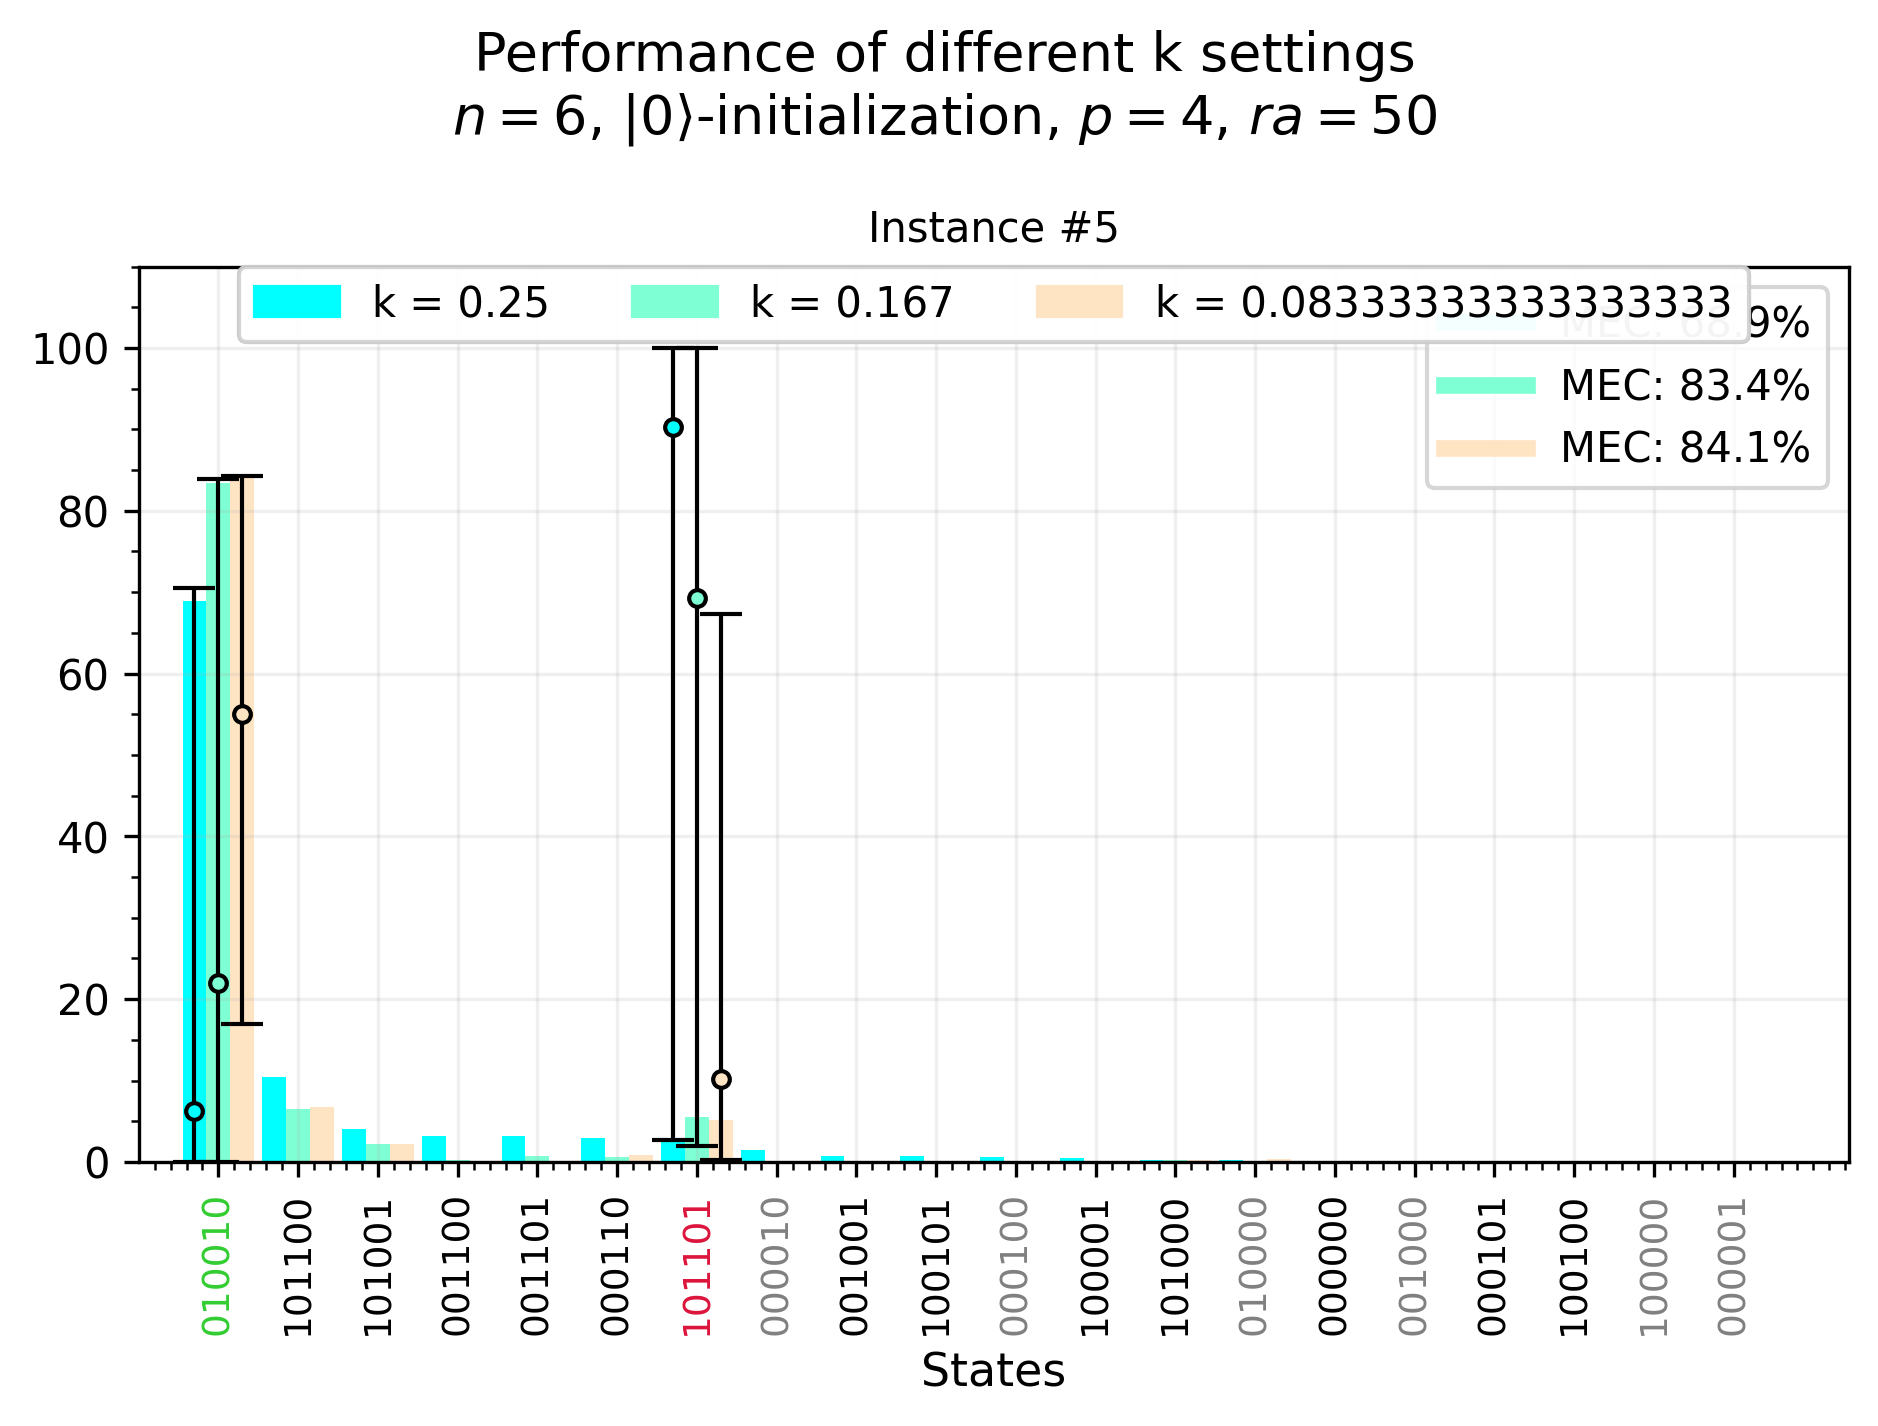

Folder 'merged_folder' deleted.


In [9]:
# list_of_folders = ["random_parameters_2025-05-31@10h57m03s", #i5
#                    "random_parameters_2025-06-01@09h35m28s", #i5
#                    "random_parameters_2025-05-31@09h27m47s", #i5
#                    "random_parameters_2025-05-29@14h34m17s", #i3
#                    "random_parameters_2025-05-29@15h44m48s" ] 

list_of_folders = ["random_parameters_2025-06-03@19h09m11s",
                    "random_parameters_2025-06-03@13h01m41s",
                    "random_parameters_2025-06-03@17h44m30s"]

multiple_barplot_from_different_folders(list_of_folders)